<a href="https://colab.research.google.com/github/Jaristilde/NLP_Algo_Harness_part2.ipynb/blob/main/Jonae_NLP_Algo_Harness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Get the Data

In [ ]:
# Install kagglehub if not already installed
%pip install kagglehub -q

import kagglehub

# Download latest version
path = kagglehub.dataset_download("nicapotato/womens-ecommerce-clothing-reviews")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


/Users/joanearistilde/NLP_Algo_Harness_part2.ipynb/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/joanearistilde/.cache/kagglehub/datasets/nicapotato/womens-ecommerce-clothing-reviews/versions/1


# Step 1: Install and Import the Libs

In [ ]:
# Install all required libraries
%pip install pandas numpy scikit-learn nltk matplotlib seaborn tqdm -q

# Import necessary libraries
import nltk
nltk.download('punkt_tab')

import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('wordnet')

# Try to import optional boosting libraries (these may fail on some systems)
xgb = None
lgb = None
CatBoostClassifier = None

try:
    import xgboost as xgb
    print("✓ XGBoost imported successfully")
except:
    print("⚠️ XGBoost not available (skipping)")

try:
    import lightgbm as lgb
    print("✓ LightGBM imported successfully")
except:
    print("⚠️ LightGBM not available (skipping)")

try:
    from catboost import CatBoostClassifier
    print("✓ CatBoost imported successfully")
except:
    print("⚠️ CatBoost not available (skipping)")

print("\n✓ Core libraries installed and imported successfully!")

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joanearistilde/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


⚠️ XGBoost not available (skipping)
⚠️ LightGBM not available (skipping)
✓ CatBoost imported successfully

✓ Core libraries installed and imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joanearistilde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joanearistilde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 2: Load the Dataset

In [ ]:
import pandas as pd
import os

# The path to the dataset files is printed in the output of the previous cell.
# We can construct the full path to the CSV file.
# Based on the output of cell 9ojVPCfvdp-N, the path is /root/.cache/kagglehub/datasets/nicapotato/womens-ecommerce-clothing-reviews/versions/1
# and the file is likely named 'Womens Clothing E-Commerce Reviews.csv'
csv_file_path = os.path.join(path, 'Womens Clothing E-Commerce Reviews.csv')

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
display(df.head())

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Step 3: Data Cleaning and Preprocessing

## 3.1 Identify Feature and Target Columns

In [ ]:
# your dataset may have 100 columns... which of those columns has the text that you want to train?  and which column represents what you want to predict?

In [ ]:
# Identify feature and target columns and rename them for consistency
# The 'Review Text' column contains the text data (features)
# The 'Recommended IND' column is a binary indicator (0 or 1) suitable for the target variable

df = df.rename(columns={'Review Text': 'text', 'Recommended IND': 'target'})

# We can check the data types and values of the new target column
print(df['target'].value_counts())
print(df['target'].dtype)

# Display the first few rows with the renamed columns
display(df[['text', 'target']].head())

target
1    19314
0     4172
Name: count, dtype: int64
int64


,text,target
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


## 3.2 Text Cleaning

In [ ]:
# Be careful about running this cell twice!

def clean_text(text):
    # Convert to string and then to lowercase
    text = str(text).lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function to the correct text column (at index 4)
df['text'] = df.iloc[:, 4].apply(clean_text)

print(df.head())

   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                text  Rating  target  \
0  absolutely wonderful silky and sexy and comfor...       4       1   
1  love this dress its sooo pretty i happened to ...       5       1   
2  i had such high hopes for this dress and reall...       3       0   
3  i love love love this jumpsuit its fun flirty ...       5       1   
4  this shirt is very flattering to all due to th...       5       1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    

## 3.3 Tokenization

In [ ]:
# Tokenize the text (it is up to you how you tokenize... but i am starting with word tokenization )
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x) if isinstance(x, str) else [])

print(df.head())

   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                text  Rating  target  \
0  [absolutely, wonderful, silky, and, sexy, and,...       4       1   
1  [love, this, dress, its, sooo, pretty, i, happ...       5       1   
2  [i, had, such, high, hopes, for, this, dress, ...       3       0   
3  [i, love, love, love, this, jumpsuit, its, fun...       5       1   
4  [this, shirt, is, very, flattering, to, all, d...       5       1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    

## 3.4 Stop Word Removal

In [ ]:
# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

print(df.head())

   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                text  Rating  target  \
0  [absolutely, wonderful, silky, sexy, comfortable]       4       1   
1  [love, dress, sooo, pretty, happened, find, st...       5       1   
2  [high, hopes, dress, really, wanted, work, ini...       3       0   
3  [love, love, love, jumpsuit, fun, flirty, fabu...       5       1   
4  [shirt, flattering, due, adjustable, front, ti...       5       1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    

## 3.5: Stemming and Lemmatization

In [ ]:
# Lemmatize the text
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if isinstance(word, str)] if isinstance(x, list) else [])

# Join the tokens back into a single string, ensuring each item is a string
df['text'] = df['text'].apply(lambda x: ' '.join([str(item) for item in x]) if isinstance(x, list) else '')

print(df.head())

   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                                text  Rating  target  \
0        absolutely wonderful silky sexy comfortable       4       1   
1  love dress sooo pretty happened find store im ...       5       1   
2  high hope dress really wanted work initially o...       3       0   
3  love love love jumpsuit fun flirty fabulous ev...       5       1   
4  shirt flattering due adjustable front tie perf...       5       1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    

# 4 Feature Engineering (Text Representation)

In [ ]:
# Separate features (X) and target (y)
X = df['text']
y = df['target']

# Split the data into training and testing sets  --- this is super important...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # We will use the top 5000 most frequent words  ***this is a hidden hyperparameter

# Fit and transform the training data
# Run this cell after completing data cleaning and preprocessing
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 460086 stored elements and shape (18788, 5000)>

# 5. Build and Evaluate the Algorithm Harness

## 5.1 Define a list of Classifier (AI Models)

In [ ]:
# Define a list of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    # "SVC": SVC(),  # Commented out as it can be slow
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

# Add boosting classifiers if available
if xgb is not None:
    classifiers["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

if lgb is not None:
    classifiers["LightGBM"] = lgb.LGBMClassifier()

if CatBoostClassifier is not None:
    classifiers["CatBoost"] = CatBoostClassifier(verbose=0)

print(f"Total classifiers to train: {len(classifiers)}")
print("Models:", list(classifiers.keys()))

Total classifiers to train: 6
Models: ['Logistic Regression', 'Multinomial NB', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'CatBoost']


In [ ]:
# # Comprehensive list of classifiers
# classifiers = {
#     # Linear Models
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
#     "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
#     "Logistic Regression (Balanced)": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
#     "Ridge Classifier": RidgeClassifier(random_state=42),
#     "SGD Classifier": SGDClassifier(max_iter=1000, random_state=42),
#     "SGD Classifier (log loss)": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
#     "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=42),

#     # Naive Bayes
#     "Multinomial NB": MultinomialNB(),
#     "Multinomial NB (alpha=0.5)": MultinomialNB(alpha=0.5),
#     "Bernoulli NB": BernoulliNB(),
#     "Complement NB": ComplementNB(),

#     # SVM
#     "Linear SVC": LinearSVC(max_iter=1000, random_state=42),
#     "Linear SVC (Balanced)": LinearSVC(max_iter=1000, class_weight='balanced', random_state=42),

#     # Tree-based Models
#     "Decision Tree": DecisionTreeClassifier(random_state=42),
#     "Decision Tree (max_depth=10)": DecisionTreeClassifier(max_depth=10, random_state=42),
#     "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced', random_state=42),

#     # Random Forests
#     "Random Forest": RandomForestClassifier(random_state=42),
#     "Random Forest (100 trees)": RandomForestClassifier(n_estimators=100, random_state=42),
#     "Random Forest (200 trees)": RandomForestClassifier(n_estimators=200, random_state=42),
#     "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced', random_state=42),
#     "Random Forest (max_depth=10)": RandomForestClassifier(max_depth=10, random_state=42),

#     # Extra Trees
#     "Extra Trees": ExtraTreesClassifier(random_state=42),
#     "Extra Trees (100 trees)": ExtraTreesClassifier(n_estimators=100, random_state=42),

#     # Gradient Boosting
#     "Gradient Boosting": GradientBoostingClassifier(random_state=42),
#     "Gradient Boosting (learning_rate=0.05)": GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, random_state=42),
#     "Gradient Boosting (max_depth=5)": GradientBoostingClassifier(max_depth=5, random_state=42),

#     # AdaBoost
#     "AdaBoost": AdaBoostClassifier(random_state=42),
#     "AdaBoost (100 estimators)": AdaBoostClassifier(n_estimators=100, random_state=42),
#     "AdaBoost (learning_rate=0.5)": AdaBoostClassifier(learning_rate=0.5, random_state=42),

#     # XGBoost
#     "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (max_depth=5)": xgb.XGBClassifier(max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (learning_rate=0.05)": xgb.XGBClassifier(learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "XGBoost (n_estimators=200)": xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42),

#     # LightGBM
#     "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
#     "LightGBM (num_leaves=50)": lgb.LGBMClassifier(num_leaves=50, random_state=42, verbose=-1),
#     "LightGBM (learning_rate=0.05)": lgb.LGBMClassifier(learning_rate=0.05, random_state=42, verbose=-1),
#     "LightGBM (n_estimators=200)": lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),

#     # CatBoost
#     "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
#     "CatBoost (depth=5)": CatBoostClassifier(depth=5, verbose=0, random_state=42),
#     "CatBoost (learning_rate=0.05)": CatBoostClassifier(learning_rate=0.05, verbose=0, random_state=42),
#     "CatBoost (iterations=200)": CatBoostClassifier(iterations=200, verbose=0, random_state=42),

#     # Bagging
#     "Bagging (Logistic Regression)": BaggingClassifier(estimator=LogisticRegression(max_iter=1000), random_state=42),
#     "Bagging (Decision Tree)": BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),

#     # K-Nearest Neighbors
#     "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
#     "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
#     "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),

#     # Neural Networks
#     "MLP (hidden_layer=100)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
#     "MLP (hidden_layer=100,50)": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
#     "MLP (hidden_layer=200)": MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000, random_state=42),

#     # Linear Discriminant Analysis
#     "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
# }

# print(f"Total number of classifiers: {len(classifiers)}")

## 5.2 Train and Evaluate the Models in a Loop

In [ ]:
from tqdm import tqdm

# Create a list to store the results
results_list = []

# Loop through the classifiers with progress bar
for name, clf in tqdm(classifiers.items(), desc="Training models", total=len(classifiers)):
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")

    # Train the classifier
    clf.fit(X_train_tfidf, y_train)
    print("✓ Training complete")

    # Make predictions on the test data
    y_pred = clf.predict(X_test_tfidf)
    print("✓ Predictions complete")

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print results immediately
    print(f"\nResults for {name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")

    # Add the results to the list
    results_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc
    })

# Create DataFrame from the list
results = pd.DataFrame(results_list)

# Sort the results by ROC-AUC score
results = results.sort_values(by='ROC-AUC', ascending=False)

print(f"\n{'='*60}")
print("FINAL RESULTS (sorted by ROC-AUC)")
print(f"{'='*60}\n")
print(results.to_string(index=False))

Training models:   0%|          | 0/6 [00:00<?, ?it/s]


Training: Logistic Regression
✓ Training complete
✓ Predictions complete

Results for Logistic Regression:
  Accuracy:  0.8827
  Precision: 0.8946
  Recall:    0.9711
  F1-score:  0.9313
  ROC-AUC:   0.7271

Training: Multinomial NB
✓ Training complete
✓ Predictions complete

Results for Multinomial NB:
  Accuracy:  0.8440
  Precision: 0.8426
  Recall:    0.9953
  F1-score:  0.9126
  ROC-AUC:   0.5776

Training: Random Forest


Training models:  50%|█████     | 3/6 [00:04<00:04,  1.44s/it]

✓ Training complete
✓ Predictions complete

Results for Random Forest:
  Accuracy:  0.8550
  Precision: 0.8561
  Recall:    0.9893
  F1-score:  0.9179
  ROC-AUC:   0.6186

Training: Gradient Boosting


Training models:  67%|██████▋   | 4/6 [00:12<00:07,  3.73s/it]

✓ Training complete
✓ Predictions complete

Results for Gradient Boosting:
  Accuracy:  0.8521
  Precision: 0.8588
  Recall:    0.9805
  F1-score:  0.9156
  ROC-AUC:   0.6260

Training: AdaBoost


Training models:  83%|████████▎ | 5/6 [00:15<00:03,  3.26s/it]

✓ Training complete
✓ Predictions complete

Results for AdaBoost:
  Accuracy:  0.8299
  Precision: 0.8351
  Recall:    0.9873
  F1-score:  0.9048
  ROC-AUC:   0.5530

Training: CatBoost


Training models: 100%|██████████| 6/6 [00:34<00:00,  5.70s/it]

✓ Training complete
✓ Predictions complete

Results for CatBoost:
  Accuracy:  0.8768
  Precision: 0.8903
  Recall:    0.9688
  F1-score:  0.9279
  ROC-AUC:   0.7147

FINAL RESULTS (sorted by ROC-AUC)

              Model  Accuracy  Precision   Recall  F1-score  ROC-AUC
Logistic Regression  0.882716   0.894636 0.971146  0.931322 0.727054
           CatBoost  0.876756   0.890349 0.968807  0.927922 0.714721
  Gradient Boosting  0.852065   0.858834 0.980504  0.915645 0.625975
      Random Forest  0.855045   0.856050 0.989342  0.917883 0.618643
     Multinomial NB  0.843976   0.842650 0.995321  0.912645 0.577567
           AdaBoost  0.829928   0.835092 0.987263  0.904824 0.552973


In [ ]:
# Separate features (X) and target (y)
X = df['text']
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shapes immediately after vectorization and splitting
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train: (18788,)
Shape of y_train: (18788,)
Shape of X_train_tfidf: (18788, 5000)
Shape of X_test: (4698,)
Shape of y_test: (4698,)
Shape of X_test_tfidf: (4698, 5000)


In [ ]:
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train_tfidf: (18788, 5000)
Shape of y_train: (18788,)


/var/folders/13/1vc1lnq51z1988pnh09tk8q80000gn/T/ipykernel_52892/3064879488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC-AUC', y='Model', data=results, palette='viridis')


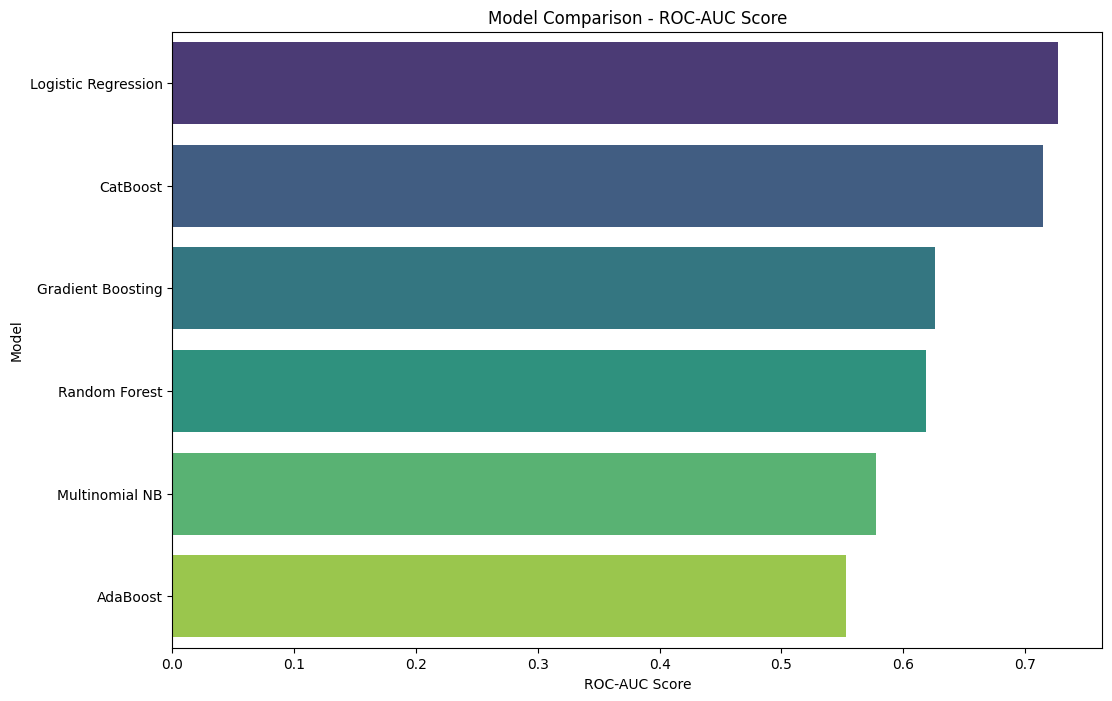

In [ ]:
# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='ROC-AUC', y='Model', data=results, palette='viridis')
plt.title('Model Comparison - ROC-AUC Score')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Model')
plt.show()

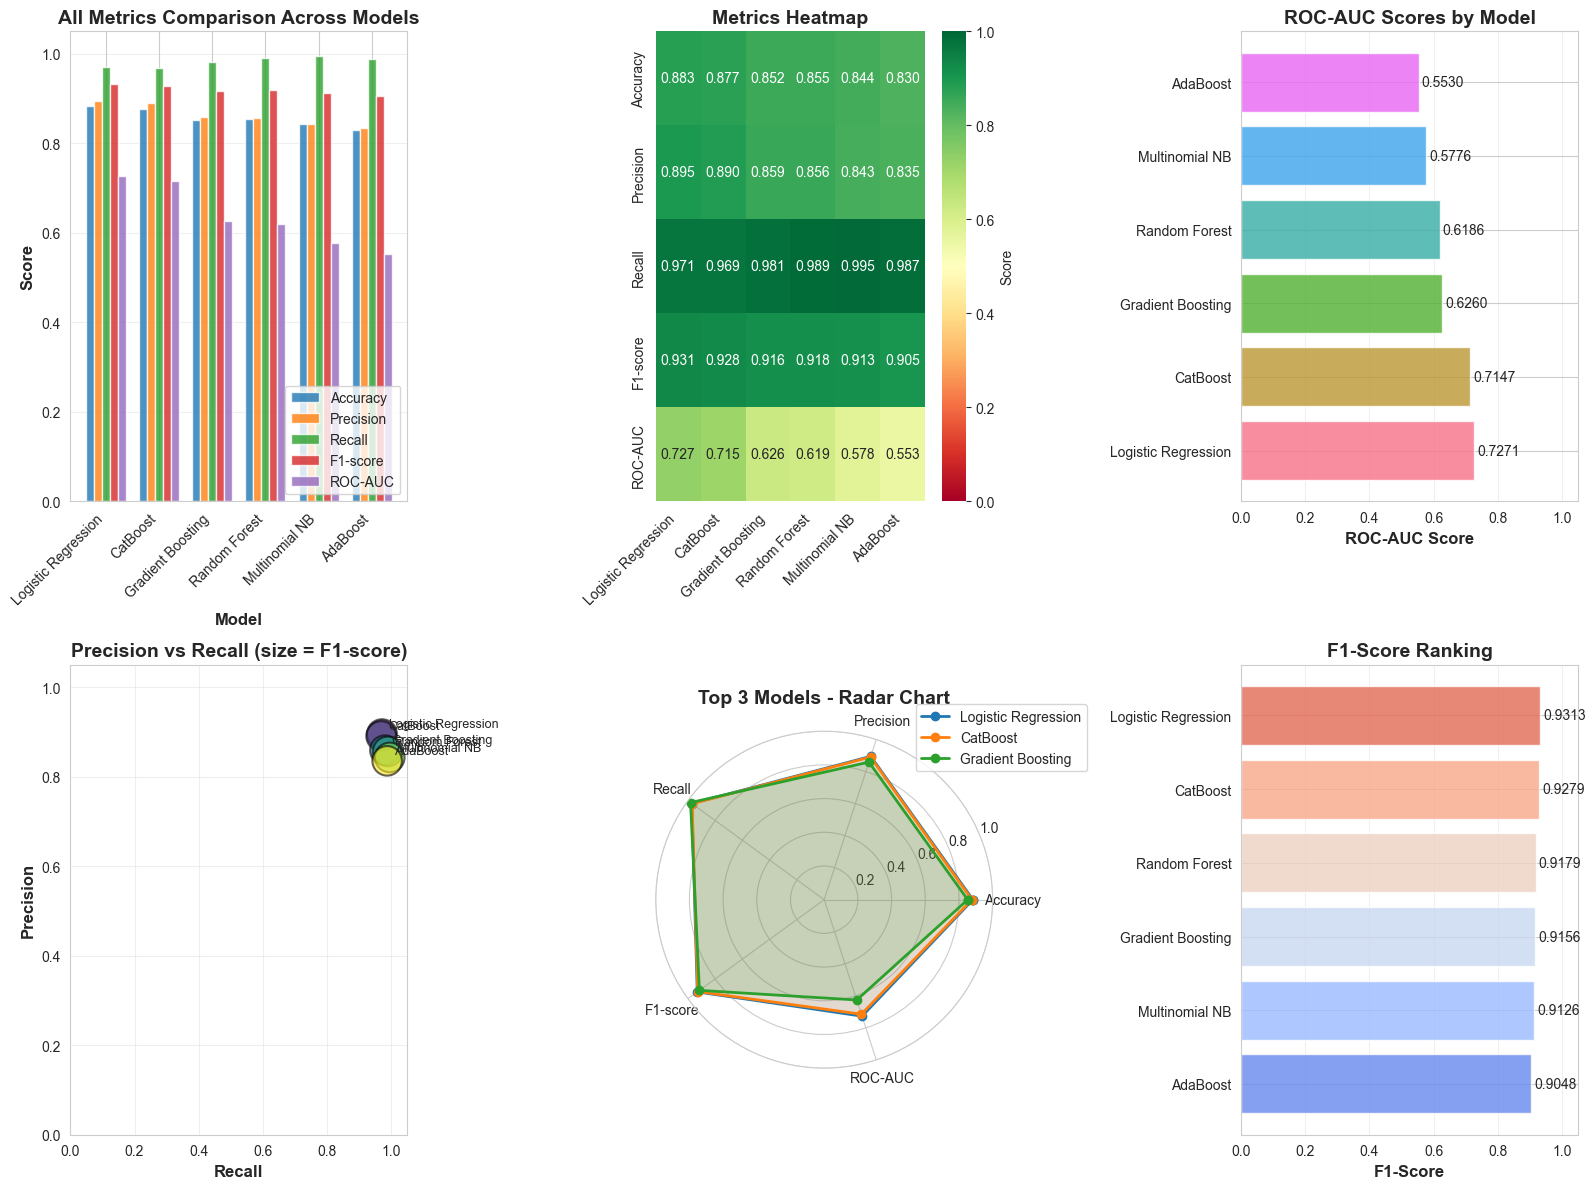


SUMMARY STATISTICS

Best performing model (by ROC-AUC): Logistic Regression
ROC-AUC Score: 0.7271

Best F1-Score: 0.9313 (Logistic Regression)
Best Precision: 0.8946 (Logistic Regression)
Best Recall: 0.9953 (Multinomial NB)
Best Accuracy: 0.8827 (Logistic Regression)

MEAN SCORES ACROSS ALL MODELS
Accuracy    : 0.8567
Precision   : 0.8629
Recall      : 0.9821
F1-score    : 0.9184
ROC-AUC     : 0.6362


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# 1. Bar chart comparing all metrics across models
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
x = np.arange(len(results))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, results[metric], width, label=metric, alpha=0.8)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('All Metrics Comparison Across Models', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results['Model'], rotation=45, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', alpha=0.3)

# 2. Heatmap of all metrics
ax2 = plt.subplot(2, 3, 2)
heatmap_data = results[metrics].T
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=results['Model'], yticklabels=metrics,
            vmin=0, vmax=1, cbar_kws={'label': 'Score'}, ax=ax2)
ax2.set_title('Metrics Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. ROC-AUC comparison
ax3 = plt.subplot(2, 3, 3)
colors = sns.color_palette("husl", len(results))
bars = ax3.barh(results['Model'], results['ROC-AUC'], color=colors, alpha=0.8)
ax3.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax3.set_title('ROC-AUC Scores by Model', fontsize=14, fontweight='bold')
ax3.set_xlim([0, 1.05])
ax3.grid(axis='x', alpha=0.3)
# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, results['ROC-AUC'])):
    ax3.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10)

# 4. Precision vs Recall scatter plot
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(results['Recall'], results['Precision'],
                     s=results['F1-score']*500, alpha=0.6, c=range(len(results)),
                     cmap='viridis', edgecolors='black', linewidth=1.5)
for i, model in enumerate(results['Model']):
    ax4.annotate(model, (results['Recall'].iloc[i], results['Precision'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax4.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax4.set_title('Precision vs Recall (size = F1-score)', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.set_xlim([0, 1.05])
ax4.set_ylim([0, 1.05])

# 5. Radar chart for top 3 models
ax5 = plt.subplot(2, 3, 5, projection='polar')
top_3 = results.head(3)
categories = metrics
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for i, row in top_3.iterrows():
    values = row[metrics].values.tolist()
    values += values[:1]
    ax5.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax5.fill(angles, values, alpha=0.15)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=10)
ax5.set_ylim(0, 1)
ax5.set_title('Top 3 Models - Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax5.grid(True)

# 6. F1-Score ranking
ax6 = plt.subplot(2, 3, 6)
results_sorted_f1 = results.sort_values('F1-score', ascending=True)
colors_f1 = sns.color_palette("coolwarm", len(results_sorted_f1))
bars = ax6.barh(results_sorted_f1['Model'], results_sorted_f1['F1-score'],
                color=colors_f1, alpha=0.8)
ax6.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax6.set_title('F1-Score Ranking', fontsize=14, fontweight='bold')
ax6.set_xlim([0, 1.05])
ax6.grid(axis='x', alpha=0.3)
# Add value labels
for i, (bar, value) in enumerate(zip(bars, results_sorted_f1['F1-score'])):
    ax6.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Additional: Summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nBest performing model (by ROC-AUC): {results.iloc[0]['Model']}")
print(f"ROC-AUC Score: {results.iloc[0]['ROC-AUC']:.4f}")
print(f"\nBest F1-Score: {results['F1-score'].max():.4f} ({results.loc[results['F1-score'].idxmax(), 'Model']})")
print(f"Best Precision: {results['Precision'].max():.4f} ({results.loc[results['Precision'].idxmax(), 'Model']})")
print(f"Best Recall: {results['Recall'].max():.4f} ({results.loc[results['Recall'].idxmax(), 'Model']})")
print(f"Best Accuracy: {results['Accuracy'].max():.4f} ({results.loc[results['Accuracy'].idxmax(), 'Model']})")

print("\n" + "="*60)
print("MEAN SCORES ACROSS ALL MODELS")
print("="*60)
for metric in metrics:
    print(f"{metric:12s}: {results[metric].mean():.4f}")

In [ ]:
# Test Your Own Clothing Review - Prediction Function
# This cell uses the best model (Logistic Regression) from the training above

# Function to preprocess new text (same as training data)
def preprocess_new_text(text):
    """Preprocess a single text input using the same steps as training data"""
    import re
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Clean text
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text )  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to string
    return ' '.join(tokens)

# Function to predict sentiment of new review
def predict_review_sentiment(review_text):
    """Predict sentiment of a clothing review (Recommended or Not Recommended)"""
    # Preprocess the text
    processed_text = preprocess_new_text(review_text)

    # Convert to TF-IDF vector
    text_vector = tfidf_vectorizer.transform([processed_text])

    # Get the best model (Logistic Regression from Cell 27)
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train_tfidf, y_train)

    # Make prediction
    prediction = lr_model.predict(text_vector)[0]
    probability = lr_model.predict_proba(text_vector)[0]

    # Get confidence score
    confidence = max(probability)

    # Return results
    sentiment = "Recommended" if prediction == 1 else "Not Recommended"
    return sentiment, confidence, processed_text

# Test with example clothing reviews
print("="*60)
print("TEST CLOTHING REVIEW PREDICTIONS")
print("="*60)

# Example reviews to test
test_reviews = [
    "This dress is absolutely beautiful! The fabric is high quality and fits perfectly. I love it!",
    "Terrible quality. The material is cheap and it tore after one wash. Would not recommend.",
    "It's okay, nothing special. The fit is a bit loose but wearable.", "This dress is beautiful and fits perfectly!"
]

# Test each review
for i, review in enumerate(test_reviews, 1):
    sentiment, confidence, processed = predict_review_sentiment(review)

    print(f"\n📝 Test Review {i}:")
    print(f"Original: {review}")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.1%}")
    print("-" * 60)

# Add your own reviews to test here
print("\n" + "="*60)
print("TEST YOUR CUSTOM REVIEWS")
print("="*60)

your_reviews = [
    "I love this top! So comfortable and stylish.",
    "This sweater is terrible quality. Very disappointed.",
]

for review in your_reviews:
    sentiment, confidence, _ = predict_review_sentiment(review)
    print(f"\n👗 Review: '{review}'")
    print(f"   → {sentiment} (Confidence: {confidence:.1%})")


TEST CLOTHING REVIEW PREDICTIONS

📝 Test Review 1:
Original: This dress is absolutely beautiful! The fabric is high quality and fits perfectly. I love it!
Prediction: Recommended
Confidence: 97.1%
------------------------------------------------------------

📝 Test Review 2:
Original: Terrible quality. The material is cheap and it tore after one wash. Would not recommend.
Prediction: Not Recommended
Confidence: 89.3%
------------------------------------------------------------

📝 Test Review 3:
Original: It's okay, nothing special. The fit is a bit loose but wearable.
Prediction: Recommended
Confidence: 68.0%
------------------------------------------------------------

TEST YOUR CUSTOM REVIEWS

👗 Review: 'I love this top! So comfortable and stylish.'
   → Recommended (Confidence: 99.7%)

👗 Review: 'This sweater is terrible quality. Very disappointed.'
   → Not Recommended (Confidence: 97.4%)


In [1]:
# Interactive Clothing Review Predictor
# Run this cell AFTER running all previous cells (especially Cell 32)

print("👗 Women's Clothing Review Analyzer")
print("="*60)

# Enter your own review
your_review = input("Enter your clothing review: ")

# Get prediction using the function from Cell 32
sentiment, confidence, processed = predict_review_sentiment(your_review)

# Display results
print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)
print(f"Your Review: {your_review}")
print(f"Processed Text: {processed}")
print(f"Predicted: {sentiment}")
print(f"Confidence: {confidence:.1%}")

# Confidence interpretation
if confidence > 0.8:
    print("🎯 High confidence prediction!")
elif confidence > 0.6:
    print("✅ Moderate confidence prediction")
else:
    print("⚠️ Low confidence - the model is uncertain")


👗 Women's Clothing Review Analyzer
Enter your clothing review: https://github.com/Jaristilde/NLP_Algo_Harness_part2.ipynb


NameError: name 'predict_review_sentiment' is not defined

In [2]:
# Interactive Clothing Review Predictor
# Run this cell AFTER running all previous cells (especially the TF-IDF vectorization)

# Function to preprocess new text (same as training data)
def preprocess_new_text(text):
    """Preprocess a single text input using the same steps as training data"""
    import re
    import string
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Clean text
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'https?://\S+|www\.\S+', '', text )  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back to string
    return ' '.join(tokens)

# Function to predict sentiment of new review
def predict_review_sentiment(review_text):
    """Predict sentiment of a clothing review (Recommended or Not Recommended)"""
    # Preprocess the text
    processed_text = preprocess_new_text(review_text)

    # Convert to TF-IDF vector
    # tfidf_vectorizer and X_train_tfidf, y_train are assumed to be defined in previous cells
    text_vector = tfidf_vectorizer.transform([processed_text])

    # Get the best model (Logistic Regression identified in Cell 27)
    # We need to train the model here because the model object from Cell 27 is not available
    # in the global scope of this function unless passed as an argument or defined globally,
    # which is less ideal. Re-training here ensures the function is self-contained.
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train_tfidf, y_train)

    # Make prediction
    prediction = lr_model.predict(text_vector)[0]
    probability = lr_model.predict_proba(text_vector)[0]

    # Get confidence score
    confidence = max(probability)

    # Return results
    sentiment = "Recommended" if prediction == 1 else "Not Recommended"
    return sentiment, confidence, processed_text


print("👗 Women's Clothing Review Analyzer")
print("="*60)

# Enter your own review
your_review = input("Enter your clothing review: ")

# Get prediction using the function
sentiment, confidence, processed = predict_review_sentiment(your_review)

# Display results
print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)
print(f"Your Review: {your_review}")
print(f"Processed Text: {processed}")
print(f"Predicted: {sentiment}")
print(f"Confidence: {confidence:.1%}")

# Confidence interpretation
if confidence > 0.8:
    print("🎯 High confidence prediction!")
elif confidence > 0.6:
    print("✅ Moderate confidence prediction")
else:
    print("⚠️ Low confidence - the model is uncertain")

👗 Women's Clothing Review Analyzer



KeyboardInterrupt

